In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import seaborn as sns
from scipy.stats import randint, uniform

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate a synthetic classification dataset
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    class_sep=0.8,
    random_state=42
)

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Create a baseline HistGradientBoostingClassifier with default parameters
base_model = HistGradientBoostingClassifier(random_state=42)
base_model.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [5]:
# Evaluate the baseline model
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)

print(f"Baseline Model Accuracy: {base_accuracy:.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_base))

Baseline Model Accuracy: 0.9170

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1030
           1       0.92      0.91      0.91       970

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [6]:
# Define parameter grid for hyperparameter tuning
param_distributions = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_leaf': randint(10, 50),
    'max_leaf_nodes': randint(20, 80),
    'l2_regularization': uniform(0, 10),
    'max_bins': randint(100, 255)
}

In [7]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # Cross-validation folds
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [8]:
# Perform hyperparameter tuning
print("\nPerforming hyperparameter tuning. This may take a while...")
random_search.fit(X_train, y_train)


Performing hyperparameter tuning. This may take a while...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12fab9160>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x137ba5970>,
                                        'max_bins': <scipy.stats._distn_infrastr...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x129f87c70>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x137b52760>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x129f87790>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x137b81610>},
                   random_state=42, scoring='accuracy', verbose=1)

In [9]:
# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.4f}")


Best Parameters: {'l2_regularization': 7.2900716804098735, 'learning_rate': 0.24138110400578372, 'max_bins': 104, 'max_depth': 12, 'max_iter': 280, 'max_leaf_nodes': 77, 'min_samples_leaf': 37}
Best Cross-Validation Accuracy: 0.9215


In [10]:
# Get the best model
best_model = random_search.best_estimator_
best_model

HistGradientBoostingClassifier(l2_regularization=7.2900716804098735,
                               learning_rate=0.24138110400578372, max_bins=104,
                               max_depth=12, max_iter=280, max_leaf_nodes=77,
                               min_samples_leaf=37, random_state=42)

In [12]:
# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nTuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement over baseline: {(tuned_accuracy - base_accuracy) * 100:.2f}%")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))


Tuned Model Accuracy: 0.9250
Improvement over baseline: 0.80%

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1030
           1       0.92      0.92      0.92       970

    accuracy                           0.93      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



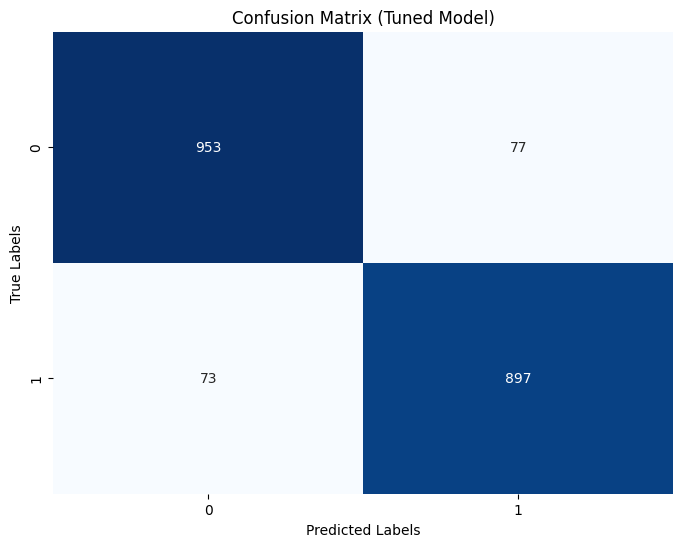

In [13]:
# Plot confusion matrix for the tuned model
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
# Calculate feature importance using permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

In [15]:
# Sort features by importance
feature_importance = pd.DataFrame({
    'Feature': [f'Feature {i}' for i in range(X.shape[1])],
    'Importance': perm_importance.importances_mean
})

In [16]:
feature_importance = feature_importance.sort_values('Importance', ascending=False)

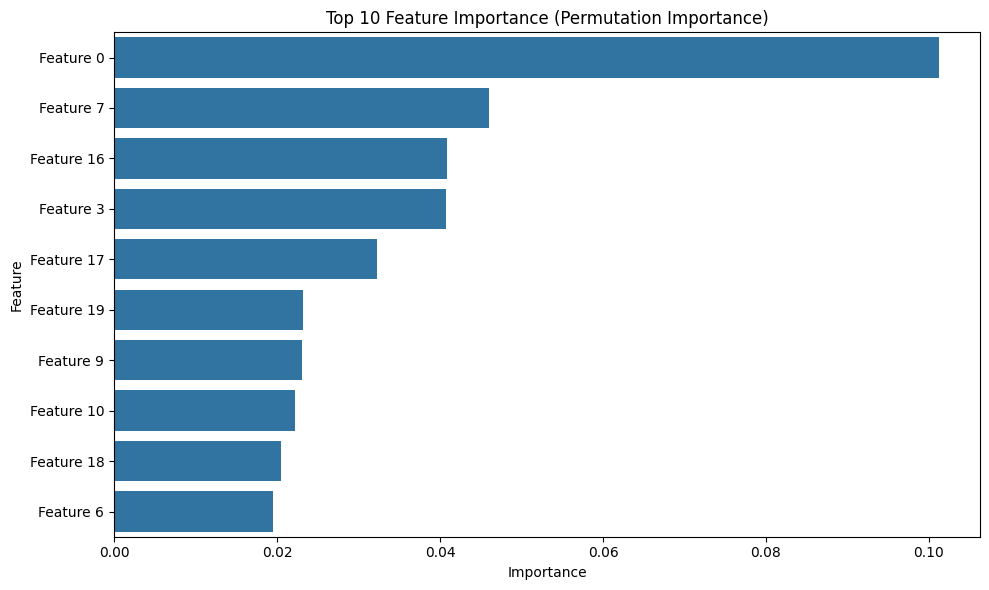

In [17]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

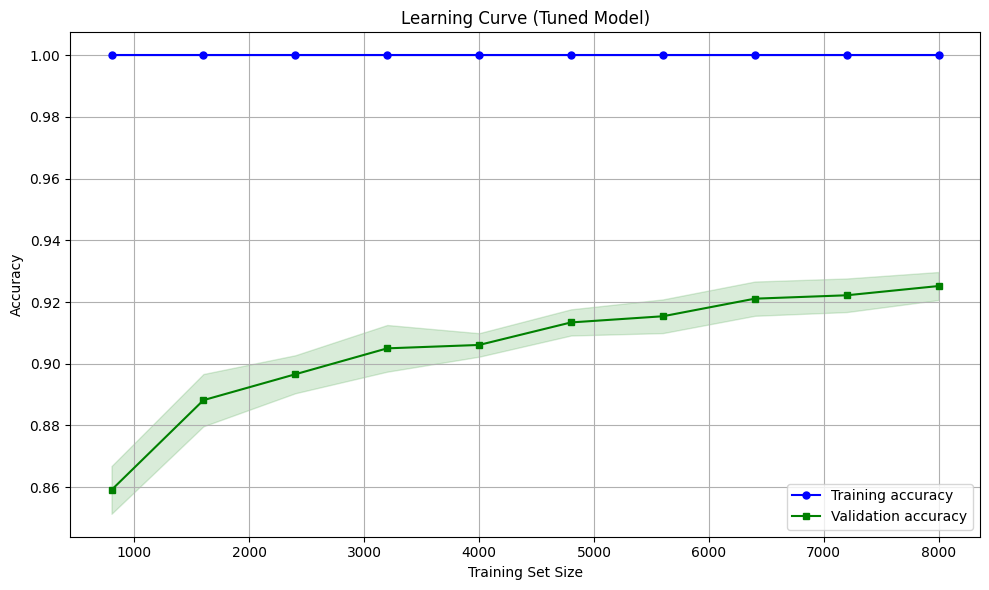

In [18]:
# Plot learning curves to assess overfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve (Tuned Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [19]:
# Example of saving and loading the model (commented out)
# import joblib

# Save the model
# joblib.dump(best_model, 'hist_gradient_boosting_model.pkl')

# Load the model
#loaded_model = joblib.load('hist_gradient_boosting_model.pkl')

In [20]:
# Example of using the model for prediction on new data
# Simulate new data (same feature count as training data)
new_data = np.random.randn(5, X.shape[1])
predictions = best_model.predict(new_data)
probabilities = best_model.predict_proba(new_data)

print("\nExample Predictions on New Data:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: Predicted class = {pred}, Probability = {prob[1]:.4f}")


Example Predictions on New Data:
Sample 1: Predicted class = 0, Probability = 0.0499
Sample 2: Predicted class = 1, Probability = 0.9836
Sample 3: Predicted class = 1, Probability = 0.6552
Sample 4: Predicted class = 1, Probability = 0.5153
Sample 5: Predicted class = 0, Probability = 0.0773
